## Utils

In [1]:
def show_gray(img,title=""):
  """
  Function to show grayscale image
  """
  plt.imshow(img,cmap='gray')
  plt.title(title)

## Download the Dataset

In [2]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1Z73UHw9IS492qxHvNUiB7-DidVl_ePfg'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [3]:
!unzip -q dataset.zip
!rm -rf dataset.zip

In [4]:
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

def MSE(image1,image2):
  """ 
  Mean Squared Error
  :param image1: image1
  :param image2: image2
  :rtype: float
  :return: MSE value
  """

  float_type = np.result_type(image1.dtype, image2.dtype, np.float32)
  image1 = np.asarray(image1, dtype=float_type)
  image2 = np.asarray(image2, dtype=float_type)

  return np.mean((image1 - image2) ** 2, dtype=np.float64)

def PSNR(image1, image2, peak=255):
  """ 
  Peak signal-to-noise ratio
  :param image1: image1
  :param image2: image2
  :param peak: max value of pixel 8-bit image (255)
  :rtype: float
  :return: PSNR value
  """

  err = mean_squared_error(image1, image2)
  return 10 * np.log10((255 ** 2) / err)
  

In [5]:
#@title Grader { vertical-output: true }
seed =  200#@param {type:"integer"}
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

np.random.seed(seed)
image1 = np.random.randint(0,256,(1280,720,3))
image2 = np.random.randint(0,256,(1280,720,3))

print(f"Skimage -> PSNR: {peak_signal_noise_ratio(image1,image2,data_range=255):.4f} | MSR: {mean_squared_error(image1,image2):.4f}")
print(f"My Func -> PSNR: {PSNR(image1,image2):.4f} | MSR: {MSE(image1,image2):.4f}")

Skimage -> PSNR: 7.7475 | MSR: 10922.7525
My Func -> PSNR: 7.7475 | MSR: 10922.7525


# Creating Noisy Images

>  MSE: To match within error of +- 2.0 \
  PSNR: To match within error of +- 200.0


## Salt n Pepper Noise
you can read about this more [here](https://en.wikipedia.org/wiki/Salt-and-pepper_noise).

## Gaussian Noise
you can read about this more [here](https://en.wikipedia.org/wiki/Gaussian_noise). 

In [6]:
from skimage.util import random_noise
from skimage import img_as_float
import numpy as np
from numba import jit

class noisy_system():
  def example(self,img,**kwargs):
    """
    An example function to test expected return.
    You can read more about skimage.util.random_noise at https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise
    """
    noisy_image = random_noise(img,**kwargs)
    noisy_image = np.uint8(noisy_image*255)
    return noisy_image

  def create_salt_and_pepper_noise(self,img,amount=0.05):
    """
    function to create salt and pepper noise
    :param image: input image
    :rtype: uint8 (w,h)
    :return: noisy image
    
    """
    img = img_as_float(img)
    
    imageSize = img.size
    numberOfRows, numberOfCols =  img.shape
    saltPercent = 0.5
    saltQuantity = int(np.ceil( saltPercent*imageSize*amount))
    pepperQuantity = int(np.ceil( (1-saltPercent)*imageSize*amount))

    saltNoise = [np.random.randint(0, numberOfRows - 1, saltQuantity), np.random.randint(0, numberOfCols - 1, saltQuantity) ]
    pepperNoise = [np.random.randint(0, numberOfRows - 1, pepperQuantity), np.random.randint(0, numberOfCols - 1, pepperQuantity) ]

    img[tuple(saltNoise)] = 1
    img[tuple(pepperNoise)] = 0

    noisyImage = np.clip(img, 0., 1.0)

    noisyImage = np.uint8(noisyImage*255)
    return noisyImage

  def create_gaussian_noise(self,img,mean=0,var=0.01):
    """
    function to create gaussian noise
    :param image: input image
    :rtype: uint8 (w,h)
    :return: noisy image
    """

    img = img_as_float(img)

    sigma = var**0.5
    noise = np.random.normal(0., sigma, img.shape)

    noisyImage = img + noise
    noisyImage = np.clip(noisyImage, 0., 1.0)

    noisyImage = np.uint8(noisyImage*255)
    return noisyImage

Total Time taken: 0.02s

Statistics:
Example   => SNP -> PSNR: 17.91 | MSE: 1053.31
Example   => GSN -> PSNR: 20.48 | MSE: 582.32
My Func   => SNP -> PSNR: 18.13 | MSE: 999.57
My Func   => GSN -> PSNR: 20.49 | MSE: 581.30


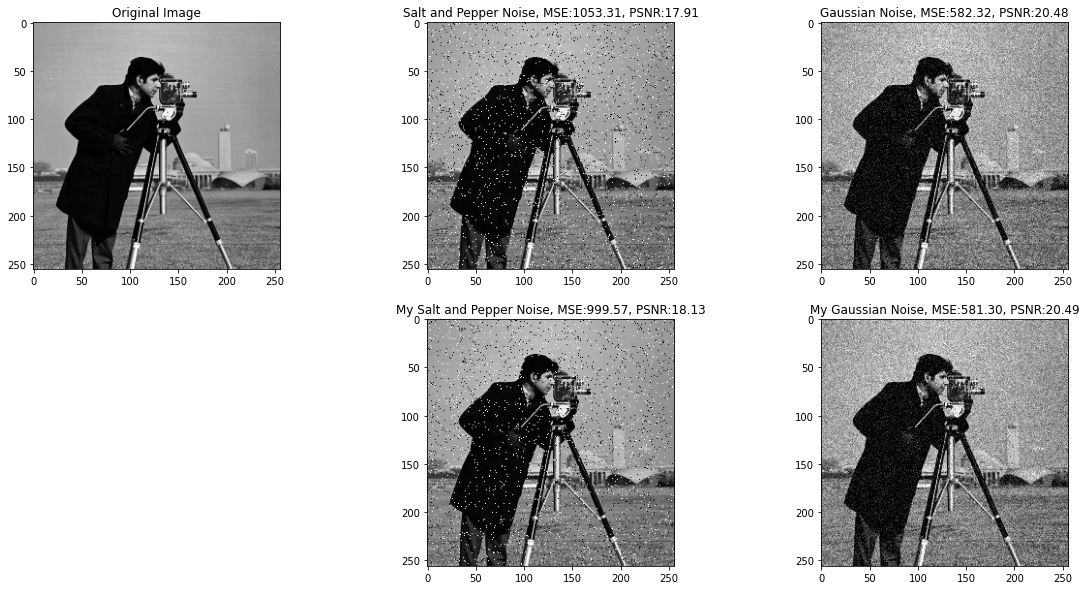

In [13]:
#@title Grader { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}

# %%timeit 
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

start = time.time()

noise_maker               = noisy_system()
image                     = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

salt_and_pepper_example   = noise_maker.example(image.copy(),mode="s&p")
gaussian_example          = noise_maker.example(image.copy(),mode="gaussian")
salt_and_pepper_image     = noise_maker.create_salt_and_pepper_noise(image.copy())
gaussian_image            = noise_maker.create_gaussian_noise(image.copy())

end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")
print("Statistics:")
print(f"Example   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Example   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"My Func   => SNP -> PSNR: {PSNR(salt_and_pepper_image,image):.2f} | MSE: {MSE(salt_and_pepper_image,image):.2f}")
print(f"My Func   => GSN -> PSNR: {PSNR(gaussian_image,image):.2f} | MSE: {MSE(gaussian_image,image):.2f}")


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
show_gray(image,"Original Image")
plt.subplot(2,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(2,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(2,3,5)
show_gray(salt_and_pepper_image,
          f"My Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_image):.2f}, PSNR:{PSNR(image,salt_and_pepper_image):.2f}")
plt.subplot(2,3,6)
show_gray(gaussian_image,
          f"My Gaussian Noise, MSE:{MSE(image,gaussian_image):.2f}, PSNR:{PSNR(image,gaussian_image):.2f}")
plt.show()

# Non Local Means

In [7]:
@jit(nopython=True)
def getWindowCoordinates(i,j,windowWidth, xLimit, yLimit):
  x = max(i-windowWidth, 0)
  y = min(i+windowWidth+1, xLimit-1)
  z = max(j-windowWidth, 0)
  w = min(j+windowWidth+1, yLimit-1)
  return x,y,z,w

@jit(nopython=True)
def denoiseImage(denoisedImage, rows, cols, small_window, bigWindowSignedSize, h, neighbours):
  i = bigWindowSignedSize

  # traversing each pixel and calculating the average value using similar pixels
  while(i < rows+ bigWindowSignedSize):
    j = bigWindowSignedSize
    while(j < cols+ bigWindowSignedSize):
      # current small window around the pixle
      currentWindow = neighbours[i,j]

      # big window around the pixel
      x,y,z,w = getWindowCoordinates(i, j, bigWindowSignedSize, rows+2*bigWindowSignedSize, cols+ 2*bigWindowSignedSize)            
      bigWindowNeighbours = neighbours[x:y, z:w]
      wightedSum = 0
      totalWeight = 0

      # Fiding the weighted sum between similar patches
      for l in range(2*bigWindowSignedSize+1):
          for m in range(2*bigWindowSignedSize+1):
              if ((l,m) != (i,j)):
                  currentNeighbour = bigWindowNeighbours[l,m]
                  currentWeight = np.exp(-1*((np.sum((currentWindow - currentNeighbour)**2)) / (h*small_window)**2))
                  wightedSum += (currentWeight*(currentNeighbour[small_window//2, small_window//2]))
                  totalWeight += currentWeight
                  
      # Clipping the result
      if wightedSum/totalWeight > 255:
          denoisedImage[i - bigWindowSignedSize, j - bigWindowSignedSize] = 255
      elif wightedSum/totalWeight < 0:
          denoisedImage[i - bigWindowSignedSize, j - bigWindowSignedSize] = 0
      else :
          denoisedImage[i - bigWindowSignedSize, j - bigWindowSignedSize] = wightedSum/totalWeight
      j += 1
    i += 1
    
  return denoisedImage


In [11]:
class NLMeans():
  """
  Non Local Means, donot change the solve function. You may add any other class 
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """
  def example(self,img,**kwargs):
    denoised_image = cv2.fastNlMeansDenoising(img,**kwargs)
    return denoised_image


  def solve(self,img,h=30,small_window=7,big_window=21):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param h: sigma h (as mentioned in the paper)
    :param small_window: size of small window
    :param big_window: size of big window
    :rtype: uint8 (w,h)
    :return: solved image
    """
    # rows and columns for image matrix
    rows,cols = img.shape
    denoisedImage = np.zeros(img.shape)
    
    # Window Widths considering the pixel as center
    bigWindowSignedSize = big_window//2
    smallWindowSignedSize = small_window//2
  
    # padding input image to avoid out of bound indexing using reflect mode
    paddedImage = np.pad(img,bigWindowSignedSize,mode='reflect')

    # 4d array for precomputing all the neighbours for all the pixels
    neighbours = np.zeros((rows+2*bigWindowSignedSize,cols+2*bigWindowSignedSize,small_window,small_window))
    
    # precomputing the neighbours for all the pixles in the padded image
    i = bigWindowSignedSize
    while(i < rows+ bigWindowSignedSize):
        j = bigWindowSignedSize
        while(j < cols+ bigWindowSignedSize):
            # getting coordinates for the small window neighbourhood
            x,y,z,w = getWindowCoordinates(i, j, smallWindowSignedSize,rows+2*bigWindowSignedSize,cols+ 2*bigWindowSignedSize)            
            neighbours[i,j] = paddedImage[x:y,z:w]
            j += 1
        i += 1

    return denoiseImage(denoisedImage, rows, cols, small_window, bigWindowSignedSize, h, neighbours)


(Inbuilt) Time taken: 0.27s

(My function) Time taken: 16.83s

Statistics:
salt_and_paper_h: 35 , gaussian_h: 26

Noisy   => SNP -> PSNR: 17.98 | MSE: 1036.24
Noisy   => GSN -> PSNR: 20.50 | MSE: 579.20
Skimage => SNP -> PSNR: 24.80 | MSE: 215.54
Skimage => GSN -> PSNR: 27.33 | MSE: 120.17
My Func => SNP -> PSNR: 24.83 | MSE: 214.08
My Func => GSN -> PSNR: 27.36 | MSE: 119.51



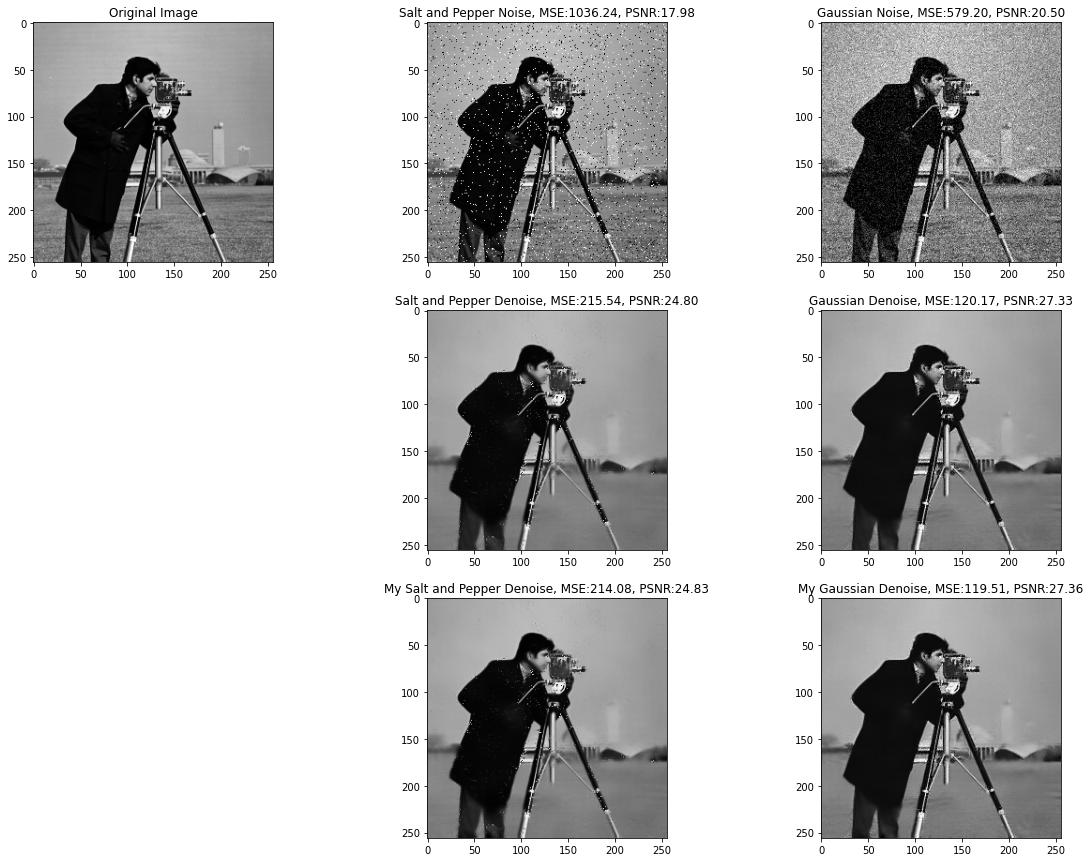

In [14]:
#@title Grader { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}
salt_and_paper_h =   35#@param {type:"integer"}
gaussian_h = 26        #@param {type:"integer"}
 
# %%timeit 
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
 
clear_output(wait=True)
 
 
denoiser                    = NLMeans()
image                       = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                       = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
salt_and_pepper_example     = noise_maker.example(image.copy(),mode="s&p")
gaussian_example            = noise_maker.example(image.copy(),mode="gaussian")
 
start = time.time()
 
salt_and_pepper_denoise     = denoiser.example(salt_and_pepper_example.copy(),h=salt_and_paper_h)
gaussian_denoise            = denoiser.example(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(Inbuilt) Time taken: {end-start:.2f}s\n")
 
start = time.time()
 
my_salt_and_pepper_denoise  = denoiser.solve(salt_and_pepper_example.copy(),h=salt_and_paper_h)
my_gaussian_denoise         = denoiser.solve(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(My function) Time taken: {end-start:.2f}s\n")
 
print("Statistics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"Skimage => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}")
print(f"My Func => SNP -> PSNR: {PSNR(my_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_salt_and_pepper_denoise,image):.2f}")
print(f"My Func => GSN -> PSNR: {PSNR(my_gaussian_denoise,image):.2f} | MSE: {MSE(my_gaussian_denoise,image):.2f}\n")
 
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
show_gray(image,"Original Image")
plt.subplot(3,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(3,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(3,3,5)
show_gray(salt_and_pepper_denoise,
          f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,6)
show_gray(gaussian_denoise,
          f"Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.subplot(3,3,8)
show_gray(my_salt_and_pepper_denoise,
          f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,9)
show_gray(my_gaussian_denoise,
          f"My Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
plt.show()

# Gaussian Filtering Comparison

In [15]:
class GaussianFilter():
  """
  GaussianFilter, donot change the solve function. You may add any other class 
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """

  def solve(self, img, ksize=(5,5), sigma_x=0):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param ksize: representing the size of the kernel.
    :param sigma_x: standard deviation in X direction
    :rtype: uint8 (w,h)
    :return: solved image
    """
    
    gaussianImage = cv2.GaussianBlur(img,ksize,sigma_x)
    return gaussianImage
    

Total Time taken: 0.01s

Statistics:
salt_and_paper_h: 35 , gaussian_h: 26

Noisy   => SNP -> PSNR: 17.98 | MSE: 1036.24
Noisy   => GSN -> PSNR: 20.50 | MSE: 579.20
Skimage => SNP -> PSNR: 24.80 | MSE: 215.54
Skimage => GSN -> PSNR: 27.33 | MSE: 120.17
My NLM Func => SNP -> PSNR: 24.83 | MSE: 214.08
My NLM Func => GSN -> PSNR: 27.36 | MSE: 119.51

My Gaussian Func => SNP -> PSNR: 23.58 | MSE: 285.28
My Gaussian Func => GSN -> PSNR: 24.21 | MSE: 246.38



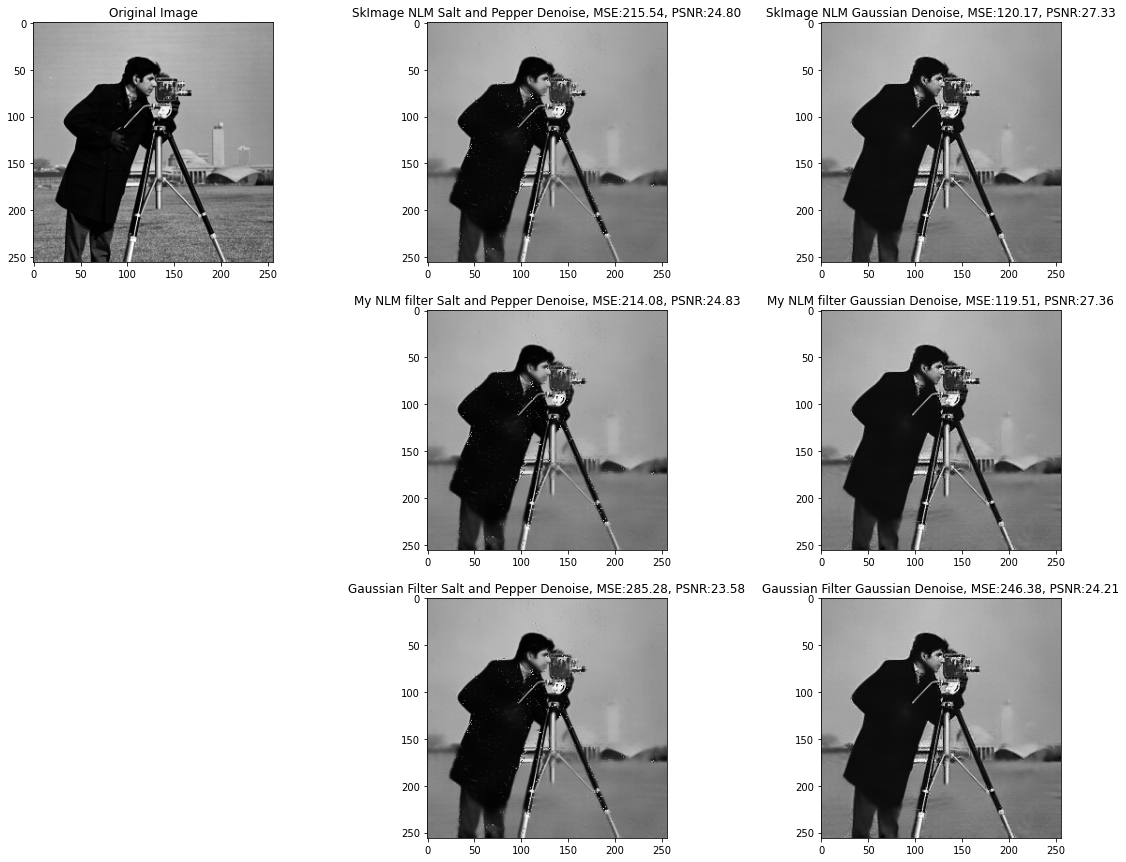

In [16]:
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

start = time.time()

denoiser_gaussian                           = GaussianFilter()

my_gaussian_salt_and_pepper_denoise         = denoiser_gaussian.solve(salt_and_pepper_example.copy())
my_gaussian_gaussian_denoise                = denoiser_gaussian.solve(gaussian_example.copy())

end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")

print("Statistics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"Skimage => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}")
print(f"My NLM Func => SNP -> PSNR: {PSNR(my_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_salt_and_pepper_denoise,image):.2f}")
print(f"My NLM Func => GSN -> PSNR: {PSNR(my_gaussian_denoise,image):.2f} | MSE: {MSE(my_gaussian_denoise,image):.2f}\n")
print(f"My Gaussian Func => SNP -> PSNR: {PSNR(my_gaussian_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_gaussian_salt_and_pepper_denoise,image):.2f}")
print(f"My Gaussian Func => GSN -> PSNR: {PSNR(my_gaussian_gaussian_denoise,image):.2f} | MSE: {MSE(my_gaussian_gaussian_denoise,image):.2f}\n")

plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
show_gray(image,"Original Image")
plt.subplot(3,3,2)
show_gray(salt_and_pepper_denoise,
          f"SkImage NLM Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,3)
show_gray(gaussian_denoise,
          f"SkImage NLM Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.subplot(3,3,5)
show_gray(my_salt_and_pepper_denoise,
          f"My NLM filter Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,6)
show_gray(my_gaussian_denoise,
          f"My NLM filter Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
plt.subplot(3,3,8)
show_gray(my_salt_and_pepper_denoise,
          f"Gaussian Filter Salt and Pepper Denoise, MSE:{MSE(image,my_gaussian_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,9)
show_gray(my_gaussian_denoise,
          f"Gaussian Filter Gaussian Denoise, MSE:{MSE(image,my_gaussian_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_gaussian_denoise):.2f}")
plt.show()